In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re

%matplotlib inline
pd.options.display.max_colwidth = 144

## Loading
First of all load all the data (files) we need for this project
- the enhanced twitter file provided
- the prediction file residing on the internet
- the twitter archive by means of the twitter api 


In [3]:
df_twitter = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
df_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [5]:
# open the url
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r=requests.get(url)

# check if it can be retrieved if so read/write the file
if r.status_code == 200:
    if url.find('/'):
        prediction_file_name = url.rsplit('/', 1)[1]              
        open(prediction_file_name,'wb').write(r.content)
    
else:
    print('open did not succeed')

In [6]:
# reopen the file and create a dataframe for it
df_predict= pd.read_csv(prediction_file_name,sep='\t')
df_predict.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [7]:
# the twitter api is in a seperate file for ease of developing this notebook
# therefore the call to read_twitter is commented out during development (used once to create the file)

from Read_twitter import read_twitter
tweets_id=list(df_twitter.tweet_id)

#read_twitter(tweets_id)

#read the file from twitter back into the notebook
df_extra=pd.read_json('tweets_json.txt',lines=True)
df_extra.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': '...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


## Check for quality and Tidiness problems in the data

In the next text blok alle issues are summarised.
The assesment and the cleaning of the data is done below this blok, just follow the links.

For me an itterative approach in searching for quality problems and solving them directly after it is found is more natural way of working.




### Quality problems


#### In the enhanced twitter data

1. [Contains retweets](#retweets)
Enhanced twitter file contains retweets as described in the project plan. 
The retweet status is an indacation for that.

2. [Remove alle not needen columns](#Remove)

3. [Timestamp is not datetime object](#timestamp)
The Timestamp field should be a datetime field instead of a object field

4. [Source field should be catagorical](#source)
The source field contains only four different URL's. Better to transform it in a catagorical dtype. For analysis it is easier to make it a shorter value

5. [Tweetid should be string](#tweetid)
The tweetid is a Int64 but should be a string

6. [The rating should be a float](#ratings)
7. [The ratings are not correct extracted](#ratings)

8. [Dognames not correct](#dognames)
Not all the names in the column name are actual dognames. This should be cleaned.

#### In the prediction data

9. [Column names in prediction file](#predict)
The column names are not very descriptive. Should be changed in more meaningfull names.

#### In the data from twitter
The data as extracted from twitter will only be used to get the retweet count and favorites count. Details of the columns can be found in this document: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
No further cleaning therefore conducted


### Tidiness problem enhanched twitter data
1. [doggo, floofer, pupper and puppo](#puppo)
are values should be in one column instead of four.

2. [Combine in one dataframe](#combine)
The three dataframes should be combined. They form one set of obeservations.


## Copy the dataframes

Perform the assesment on the original dataframes, perform the cleaning on the copied dataframes.

In [20]:
clean_twitter = df_twitter.copy()
clean_predict = df_predict.copy()
clean_extra = df_extra.copy()

## Assessing and Cleaning in one go!
<a id='retweets'></a>
### 1. Retweets
Remove all retweets from the extended twitter dataframe. We want only tweets for this project.

In [21]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [22]:
#a few data rows with retweets
df_twitter[['tweet_id','text', 'retweeted_status_id']].iloc[880:895,:]
# retweets are marked in the text with RT @.......

,tweet_id,text,retweeted_status_id
880,760539183865880579,This is Atlas. Swinging is his passion. 12/10 would push all day https://t.co/9k8LLjJ0uJ,NaN
881,760521673607086080,"Doggo want what doggo cannot have. Temptation strong, dog stronger. 12/10 https://t.co/IqyTF6qik6",NaN
882,760290219849637889,This is Rocco. He's doing his best. 13/10 someone help him (IG: rocco_roni) https://t.co/qFsl1nnXMv,NaN
883,760252756032651264,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably...,NaN
884,760190180481531904,Meet Sadie. She's addicted to balloons. It's tearing her family apart. Won't admit she has a problem. Stil...,NaN
885,760153949710192640,"RT @hownottodraw: The story/person behind @dog_rates is heckin adorable af. 11/10, probably would pet. htt...",7.601538e+17
886,759943073749200896,Here's a wicked fast pupper. 12/10 camera could barely keep pup https://t.co/HtAR6gpUAu,NaN
887,759923798737051648,We only rate dogs... this is a Taiwanese Guide Walrus. Im getting real heckin tired of this. Please send d...,NaN
888,759846353224826880,This is Kirby. He's a Beneblip Cumberpat. Pretty heckin rare. 11/10 would put my face against his face htt...,NaN
889,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at...",NaN


In [23]:
clean_twitter.query('tweet_id == 761371037149827077')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
872,761371037149827077,NaN,NaN,2016-08-05 01:19:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Oh. My. God. 13/10 magical af https://t.co/Ezu6jQrKAZ,7.116948e+17,4.196984e+09,2016-03-20 23:23:54 +0000,"https://twitter.com/dog_rates/status/711694788429553666/photo/1,https://twitter.com/dog_rates/status/71169...",13,10,None,None,None,None,None


In [24]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


In [25]:
#We need only tweets, retweets are indicated with retweet_status_id, in total
#181 rows have to be deleted from the frame. (from df_twitter.info: 6   retweeted_status_id         181 non-null    float64)
#Select the rows to be removed.

total_rows=clean_twitter.shape[0]
a=clean_twitter.retweeted_status_id.dropna()
clean_twitter.drop(labels=a.index,inplace=True)

In [26]:
#Test if the 181 rows are gone. 2356 - 181 = 2175
clean_twitter.info()
print('Removed lines: {}'.format(total_rows - clean_twitter.shape[0]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [27]:
clean_twitter.query('tweet_id == 761371037149827077')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [28]:
clean_twitter.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None


<a id='remove'></a> 
### 2 Remove not needed columns
There are a number of columns not needed for the analysis


In [29]:
#Remove the 2 reply* columns and the 3 retweet* colums
total_columns=clean_twitter.shape[1]
clean_twitter = clean_twitter.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)
clean_twitter = clean_twitter.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

In [30]:
clean_twitter.info()
# below the 5 columns should have gone
print('Removed columns: {}'.format(total_columns - clean_twitter.shape[1]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2175 non-null   int64 
 1   timestamp           2175 non-null   object
 2   source              2175 non-null   object
 3   text                2175 non-null   object
 4   expanded_urls       2117 non-null   object
 5   rating_numerator    2175 non-null   int64 
 6   rating_denominator  2175 non-null   int64 
 7   name                2175 non-null   object
 8   doggo               2175 non-null   object
 9   floofer             2175 non-null   object
 10  pupper              2175 non-null   object
 11  puppo               2175 non-null   object
dtypes: int64(3), object(9)
memory usage: 144.4+ KB
Removed columns: 5


<a id='Timestamp'></a>
### 3 Change Timestamp


In [31]:
#convert the timestamp to a datetime object (from df_twitter.info 3   timestamp                   2356 non-null   object)
clean_twitter.timestamp = pd.to_datetime(clean_twitter.timestamp)

In [32]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   object             
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

In [33]:
clean_twitter.timestamp.head(1)

0   2017-08-01 16:23:56+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

<a id='source'></a>
### 4. Change source column
Source is object change it to catagorical after replacing the URL content to shorter descriptions.


In [34]:
#Get the values
clean_twitter.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [35]:
#There are only 4 values in URL format replace it with a shorthand notation
clean_twitter.source=clean_twitter.source.str.extract('(iPhone|Vine|Web|TweetDeck)')

#Check the result
clean_twitter.source.value_counts()

iPhone       2042
Vine           91
Web            31
TweetDeck      11
Name: source, dtype: int64

In [36]:
#Change the dtype to category (from df_twitter.info  4   source                      2356 non-null   object)
clean_twitter.source=clean_twitter.source.astype('category')

In [37]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   int64              
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

<a id='tweetid'></a>
### 5. Tweet_id convert to string
The tweetid can be very long according the twitter specification

In [42]:
#the column tweet_id should be of type object not Int64
clean_twitter.tweet_id = clean_twitter.tweet_id.astype(str)
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   int64              
 6   rating_denominator  2175 non-null   int64              
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [43]:
#The same operation for the other two dataframes
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [44]:
#the column tweet_id should be of type object not Int64
clean_predict.tweet_id = clean_predict.tweet_id.astype(str)
clean_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


In [45]:
df_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [163]:
clean_extra.id = clean_extra.id.astype(str)
clean_extra.rename(columns={'id':'tweet_id'},inplace=True)
clean_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   tweet_id                       2331 non-null   object             
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

<a id='ratings'></a>
### 6&7. Ratings
The ratings have several quality problems. 
First of all, the data is not always extrated in the correct way
Second Numerator and denominator should be floats as a rating can be 13.5/10


In [47]:
clean_twitter.text.sample(10)

873          This is Bruce. I really want to hear the joke he was told. 10/10 for chuckle pup https://t.co/ErPLjjJOKc
647                   Your favorite squad is looking extra h*ckin spooky today. 13/10 for all https://t.co/PrgvOyPtDT
790     This is Heinrich (pronounced "Pat"). He's a Botswanian Vanderfloof. Snazzy af bandana. 12/10 downright pup...
2257    Meet Olive. He comes to spot by tree to reminisce of simpler times and truly admire his place in the unive...
2000    This is Jackie. She was all ready to go out, but her friends just cancelled on her. 10/10 hang in there Ja...
459     This is Buddy. He ran into a glass door once. Now he's h*ckin skeptical. 13/10 empowering af (vid by Britt...
1477           When you keepin the popcorn bucket in your lap and she reach for some... 10/10 https://t.co/a1IrjaID3X
326     Meet Charlie. She asked u to change the channel to Animal Planet at least 6 times. Now taking matters into...
2256    This is Calvin. He is a Luxembourgian Mayo. Havi

In [52]:
df_twitter.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [53]:
clean_twitter[['rating_numerator','rating_denominator']]=clean_twitter.text.str.extract('([0-9]+\.?[0-9]*)\/([0-9]+\.?[0-9]*)')

In [54]:
#search for a floating value 11.26 and 13.5 checking if they are correct extracted
clean_twitter[clean_twitter.text.str.contains('11.26')]['tweet_id']

1712    680494726643068929
Name: tweet_id, dtype: object

In [61]:
clean_twitter.query('tweet_id == "680494726643068929"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


In [62]:
clean_twitter[clean_twitter.text.str.contains('13.5')]['tweet_id']

45    883482846933004288
Name: tweet_id, dtype: object

In [63]:
clean_twitter.query('tweet_id == "883482846933004288"')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10


In [64]:
clean_twitter = clean_twitter.astype({'rating_numerator': 'float', 'rating_denominator': 'float'})

In [65]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   name                2175 non-null   object             
 8   doggo               2175 non-null   object             
 9   floofer             2175 non-null   object             
 10  pupper              2175 non-null   object             
 11  puppo               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

<a id='dognames'></a>
### 8. Dognames
Clean the columns name. Not alle the values are actual dognames.
Of course not alle tweets have a dogname in the text.

In [66]:
df_twitter.name.value_counts()

None         745
a             55
Charlie       12
Oliver        11
Lucy          11
            ... 
Philippe       1
Socks          1
Mollie         1
Jazzy          1
Scruffers      1
Name: name, Length: 957, dtype: int64

In [67]:
#Some checking if the text contains no dogname
df_twitter.query('name == "None"')['text']

5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek h...
7        When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq
12                   Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm
24                                     You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV
25      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t....
                                                                             ...                                                                       
2342                      Here we have a well-established sunblockerspaniel. Lost his ot

As can been seen, dognames are for example None, which is correct. Not all twitter text fields contain a dogname. Further names are normal written with the first letter a Capital letter. So Charlie would be a dogname and light would be not a name. So checking if alle names start with capital letter and if not we replave it with None.

In [68]:
# Search for all non dognames
clean_twitter['name'].str.extract('(^[a-z][a-z]*)').value_counts()

a               55
the              8
an               6
one              4
very             4
just             3
quite            3
actually         2
not              2
getting          2
infuriating      1
all              1
this             1
by               1
his              1
incredibly       1
space            1
life             1
light            1
unacceptable     1
my               1
officially       1
old              1
such             1
mad              1
dtype: int64

In [69]:
#Create a new column with a meaningfull name and for safety
clean_twitter['dogname']=clean_twitter.name.str.replace('(^[a-z][a-z]*)','None')

In [71]:
#Crosscheck
clean_twitter[['name','dogname']].sample(25)

,name,dogname
760,Nala,Nala
1084,None,None
1916,life,None
1791,None,None
1899,Jeb,Jeb
1699,None,None
816,Winston,Winston
173,Sophie,Sophie
861,Belle,Belle
2149,None,None


In [72]:
#Another check, should be empty
clean_twitter['dogname'].str.extract('(^[a-z][a-z]*)').value_counts()

Series([], dtype: int64)

In [73]:
#Remove the old column name from the dataframe
clean_twitter.drop(columns='name',axis=1,inplace=True)

In [74]:
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   doggo               2175 non-null   object             
 8   floofer             2175 non-null   object             
 9   pupper              2175 non-null   object             
 10  puppo               2175 non-null   object             
 11  dogname             2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC

In [75]:
#check for duplicates
clean_twitter.duplicated('tweet_id').sum()

0

In [76]:
clean_twitter.shape

(2175, 12)

<a id='predict'></a>
### 9. Meaningfull column names

The prediction has three predictions in row, each with a breed {P1..P3}, a Confidence level {P1_conf...P3_conf} and a boolean indicating if it is a dog or not.

The names will be changed to
- First_guess, Second_guess, Third_guess
- First_confidence, Second_confidence, Third_confidence
- First_dog, Second_dog, Third_dog



In [77]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [82]:
clean_predict.rename(columns={'p1': 'First_breed',
                              'p2': 'Second_breed',
                              'p3': 'Third_breed'}, inplace=True)

In [83]:
clean_predict.rename(columns={'p1_conf': 'First_confidence',
                              'p2_conf': 'Second_confidence',
                              'p3_conf': 'Third_confidence'}, inplace=True)

In [84]:
clean_predict.rename(columns={'p1_dog': 'First_dog',
                              'p2_dog': 'Second_dog',
                              'p3_dog': 'Third_dog'}, inplace=True)

In [85]:
clean_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2075 non-null   object 
 1   jpg_url            2075 non-null   object 
 2   img_num            2075 non-null   int64  
 3   First_breed        2075 non-null   object 
 4   First_confidence   2075 non-null   float64
 5   First_dog          2075 non-null   bool   
 6   Second_breed       2075 non-null   object 
 7   Second_confidence  2075 non-null   float64
 8   Second_dog         2075 non-null   bool   
 9   Third_breed        2075 non-null   object 
 10  Third_confidence   2075 non-null   float64
 11  Third_dog          2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 111.5+ KB


<a id='tidy'></a><a id='puppo'></a>
### Tidiness
There are two issues to resolve
1. The doge stages should be in one column instead of four
2. The tables should be combined to one meaningfull dataset

In [86]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [152]:
#create a new column with all dog stages in the column
clean_twitter['stage'] = clean_twitter[['doggo', 'floofer','pupper','puppo']].apply(lambda x: "".join(x).replace('None',''), axis=1)

In [154]:
#check the result
clean_twitter.stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [156]:
#we have to correct a few values
clean_twitter.stage=clean_twitter.stage.str.replace('doggop','doggo,p')
clean_twitter.stage=clean_twitter.stage.str.replace('doggof','doggo,f')
clean_twitter.stage.value_counts()

                 1831
pupper            224
doggo              75
puppo              24
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: stage, dtype: int64

In [157]:
#remove the obsolete columns
clean_twitter.drop(columns=['doggo', 'floofer','pupper','puppo'],inplace=True)
clean_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
dtypes: category(1), datetime64[ns, UTC](1), float64(2), object(5)
memory usage: 112.7+ KB


In [158]:
clean_twitter.sample(15)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage
2333,666337882303524864,2015-11-16 19:31:45+00:00,iPhone,This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL,https://twitter.com/dog_rates/status/666337882303524864/photo/1,9.0,10.0,None,
398,825026590719483904,2017-01-27 17:04:02+00:00,iPhone,Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps://t.co/koHvVQp9...,"https://www.gofundme.com/my-puppys-double-cataract-surgery,https://twitter.com/dog_rates/status/825026590719483904/photo/1,https://twitter.c...",12.0,10.0,Pablo,puppo
968,750147208377409536,2016-07-05 02:00:06+00:00,iPhone,"And finally, happy 4th of July from the squad 🇺🇸 13/10 for all https://t.co/Mr8Lr3iOUe",https://twitter.com/dog_rates/status/750147208377409536/photo/1,13.0,10.0,None,
253,844704788403113984,2017-03-23 00:18:10+00:00,iPhone,This is Luna. It's her first time outside and a bee stung her nose. Completely h*ckin uncalled for. 13/10 where's the bee I just wanna talk ...,https://twitter.com/dog_rates/status/844704788403113984/photo/1,13.0,10.0,Luna,
1353,703769065844768768,2016-02-28 02:29:55+00:00,iPhone,When you're trying to watch your favorite tv show but your friends keep interrupting. 10/10 relatable af https://t.co/QQZDCYl6zT,"https://twitter.com/dog_rates/status/703769065844768768/photo/1,https://twitter.com/dog_rates/status/703769065844768768/photo/1",10.0,10.0,None,
509,812466873996607488,2016-12-24 01:16:12+00:00,iPhone,This is Mary. She's desperately trying to recreate her Coachella experience. 12/10 downright h*ckin adorable https://t.co/BAJrfPvtux,https://twitter.com/dog_rates/status/812466873996607488/photo/1,12.0,10.0,Mary,
2013,672231046314901505,2015-12-03 01:49:05+00:00,iPhone,Exotic underwater dog here. Very shy. Wont return tennis balls I toss him. Never been petted. 5/10 I bet he's soft https://t.co/WH7Nzc5IBA,https://twitter.com/dog_rates/status/672231046314901505/photo/1,5.0,10.0,None,
52,882045870035918850,2017-07-04 01:18:17+00:00,iPhone,"This is Koko. Her owner, inspired by Barney, recently built a cart for her to use during walks if she got tired. 13/10 rest easy Koko https:...","https://twitter.com/dog_rates/status/882045870035918850/photo/1,https://twitter.com/dog_rates/status/882045870035918850/photo/1,https://twit...",13.0,10.0,Koko,
184,856526610513747968,2017-04-24 15:13:52+00:00,iPhone,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",https://twitter.com/dog_rates/status/856526610513747968/photo/1,14.0,10.0,None,
1019,746790600704425984,2016-06-25 19:42:08+00:00,iPhone,When you just can't resist... 10/10 topnotch tongue https://t.co/jeWEGUgbXf,"https://twitter.com/dog_rates/status/746790600704425984/photo/1,https://twitter.com/dog_rates/status/746790600704425984/photo/1,https://twit...",10.0,10.0,None,


 <a id='combine'></a>
 ### Create one final dataframe

In [176]:
clean_twitter.shape, clean_extra.shape, clean_predict.shape

((2175, 9), (2331, 32), (2075, 12))

In [189]:
df_tmp=clean_twitter.merge(clean_extra, on='tweet_id', how='left')[['tweet_id','retweet_count','favorite_count']]

In [190]:
twitter_tmp=pd.merge(clean_twitter,df_tmp,on='tweet_id', how='inner' )

In [191]:
twitter_master=pd.merge(twitter_tmp,clean_predict,on='tweet_id', how='left')

In [192]:
twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2175 non-null   object             
 1   timestamp           2175 non-null   datetime64[ns, UTC]
 2   source              2175 non-null   category           
 3   text                2175 non-null   object             
 4   expanded_urls       2117 non-null   object             
 5   rating_numerator    2175 non-null   float64            
 6   rating_denominator  2175 non-null   float64            
 7   dogname             2175 non-null   object             
 8   stage               2175 non-null   object             
 9   retweet_count       2168 non-null   float64            
 10  favorite_count      2168 non-null   float64            
 11  jpg_url             1994 non-null   object             
 12  img_num             1994 non-null 

In [193]:
twitter_master.sample(12)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dogname,stage,retweet_count,...,img_num,First_breed,First_confidence,First_dog,Second_breed,Second_confidence,Second_dog,Third_breed,Third_confidence,Third_dog
1485,682788441537560576,2016-01-01 05:00:24+00:00,iPhone,Happy New Year from your fav holiday squad! 🎉 12/10 for all\n\nHere's to a pupper-filled year 🍻🐶🐶🐶 https://t.co/ZSdEj59FGf,https://twitter.com/dog_rates/status/682788441537560576/photo/1,12.0,10.0,None,pupper,1071.0,...,1.0,toyshop,0.375610,False,orange,0.094538,False,teddy,0.039808,False
1897,670838202509447168,2015-11-29 05:34:25+00:00,iPhone,Pink dogs here. Unreasonably long necks. Left guy has only 1 leg. Quite nimble. Don't bark tho 4/10s would still pet https://t.co/QY5uvMmmQk,https://twitter.com/dog_rates/status/670838202509447168/photo/1,4.0,10.0,None,,642.0,...,1.0,flamingo,0.992710,False,coral_fungus,0.003491,False,stinkhorn,0.001859,False
1879,671347597085433856,2015-11-30 15:18:34+00:00,iPhone,This is Lola. She was not fully prepared for the water slide. 9/10 https://t.co/svlkUlg3NH,"https://twitter.com/dog_rates/status/671347597085433856/photo/1,https://twitter.com/dog_rates/status/671347597085433856/photo/1",9.0,10.0,Lola,,394.0,...,1.0,picket_fence,0.382918,False,rain_barrel,0.108809,False,plastic_bag,0.038878,False
1677,675522403582218240,2015-12-12 03:47:46+00:00,iPhone,Meet Sammy. He's a Motorola Firefox. Hat under hoodie (must be a half-decent up and coming white rapper) 10/10 https://t.co/rO2zxf0OQ0,https://twitter.com/dog_rates/status/675522403582218240/photo/1,10.0,10.0,Sammy,,271.0,...,1.0,cocker_spaniel,0.299708,True,golden_retriever,0.263665,True,Irish_setter,0.080323,True
1469,683773439333797890,2016-01-03 22:14:26+00:00,iPhone,This is Buddy. He's gaining strength. Currently an F4 tornado with wind speeds up to 260mph. Very devastating. 9/10 https://t.co/qipZbshNsR,https://twitter.com/dog_rates/status/683773439333797890/photo/1,9.0,10.0,Buddy,,1295.0,...,1.0,miniature_pinscher,0.072885,True,Labrador_retriever,0.057866,True,schipperke,0.053257,True
981,724046343203856385,2016-04-24 01:24:35+00:00,iPhone,"This is Sarge. Not even he knows what his tongue is doing, but it's pretty damn spectacular. 10/10 https://t.co/pIQEdbBxdL",https://twitter.com/dog_rates/status/724046343203856385/photo/1,10.0,10.0,Sarge,,539.0,...,1.0,boxer,0.826272,True,bull_mastiff,0.158595,True,Great_Dane,0.011859,True
207,846505985330044928,2017-03-27 23:35:28+00:00,iPhone,THIS WAS NOT HIS FAULT HE HAD NO IDEA. 11/10 STILL A VERY GOOD DOG https://t.co/GJ8rozumsy,https://twitter.com/shomaristone/status/846484798663245829,11.0,10.0,None,,2933.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,780459368902959104,2016-09-26 17:29:48+00:00,iPhone,"This is Bear. Don't worry, he's not a real bear tho. Contains unreal amounts of squish. 11/10 heteroskedastic af https://t.co/coi4l1T2Sm",https://twitter.com/dog_rates/status/780459368902959104/photo/1,11.0,10.0,Bear,,1061.0,...,1.0,Great_Dane,0.382491,True,German_shepherd,0.312026,True,bull_mastiff,0.033272,True
773,752519690950500352,2016-07-11 15:07:30+00:00,iPhone,Hopefully this puppo on a swing will help get you through your Monday. 11/10 would push https://t.co/G54yClasz2,"https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twitter.com/dog_rates/status/752519690950500352/photo/1,https://twit...",11.0,10.0,None,puppo,3361.0,...,3.0,swing,0.999984,False,Labrador_retriever,0.000010,True,Eskimo_dog,0.000001,True
2039,668507509523615744,2015-11-22 19:13:05+00:00,iPhone,This is a Birmingham Quagmire named Chuk. Loves to relax and watch the game while sippin on that iced mocha. 10/10 https://t.co/HvNg9JWxFt,https://twitter.com/dog_rates/status/668507509523615744/photo/1,10.0,10.0,None,,95.0,...,1.0,basenji,0.055379,True,Shetland_sheepdog,0.054322,True,whippet,0.051913,True


In [196]:
#write the cleaned data to a file
twitter_master.to_csv('twitter_archive_master.csv')

## Insights

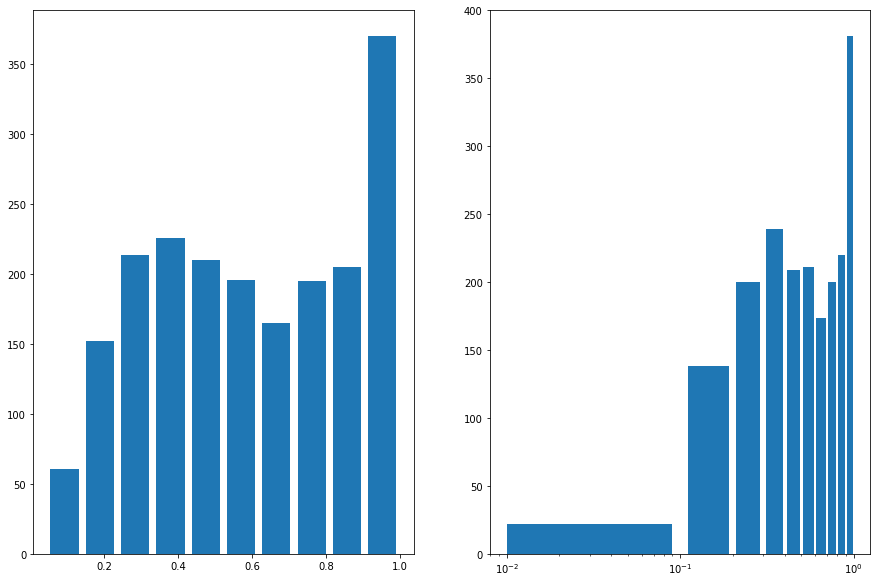

In [266]:
plt.figure(figsize=(15,10))

bins=np.arange(0,1.1,0.1)
plt.subplot(1,2,1)
plt.hist(twitter_master.First_confidence,rwidth=0.8);

plt.subplot(1,2,2)
plt.xscale('log')
plt.hist(twitter_master.First_confidence,rwidth=0.8,bins=bins);

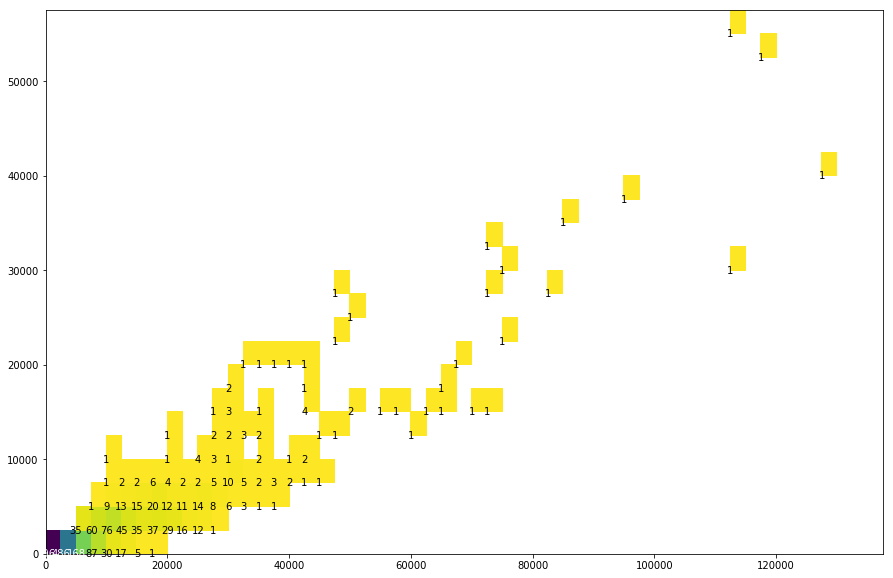

In [298]:
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
plt.figure(figsize=(15,10))
tmp_master=twitter_master.dropna(subset=['retweet_count','favorite_count'])
bins_x = np.arange(0,140000,2500)
bins_y= np.arange(0,60000,2500)
#sns.regplot(twitter_master.favorite_count,twitter_master.retweet_count);
h2d=plt.hist2d(data=tmp_master,x='favorite_count',y='retweet_count',cmin=0.5,cmap='viridis_r',bins=[bins_x,bins_y]);
counts=h2d[0]
for i in range(counts.shape[0]):
    for j in range(counts.shape[1]):
        c = counts[i,j]
        if c >= 100: # increase visibility on darker cells
            plt.text(bins_x[i]+0.5, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'white')
        elif c > 0:
            plt.text(bins_x[i]+0.5, bins_y[j]+0.5, int(c),
                     ha = 'center', va = 'center', color = 'black')

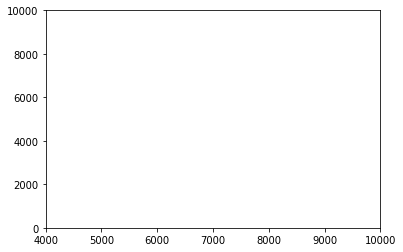

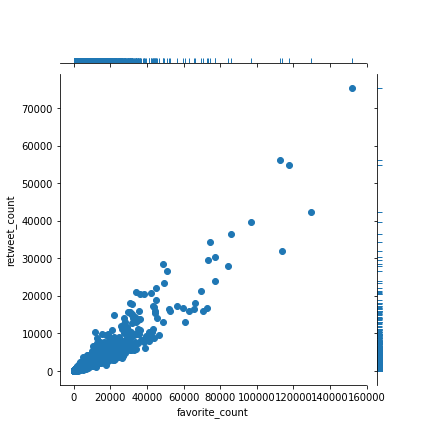

In [411]:
base_color = sns.color_palette()[0]

plt.xlim(4000,10000)
plt.ylim(0,10000)
g = sns.JointGrid(data=tmp_master, x='favorite_count',y='retweet_count');
g.plot_joint(plt.scatter)
g.plot_marginals(sns.rugplot, height = 0.1)





(0, 10000)

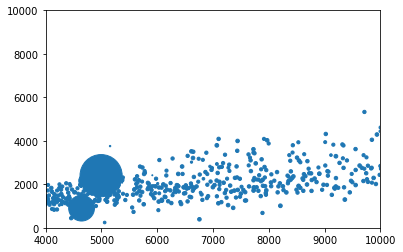

In [405]:
plt.scatter(data=tmp_master,x='favorite_count',y='retweet_count',s='rating_numerator');
plt.xlim(4000,10000)
plt.ylim(0,10000)

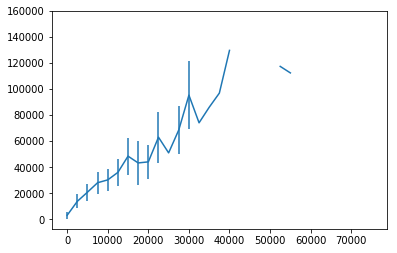

In [340]:
xbins=np.arange(0,80000,2500)
bin_centers = xbins[:-1] + 10
displ_binned = pd.cut(twitter_master['retweet_count'], xbins, include_lowest = True)
displ_binned

comb_mean = twitter_master['favorite_count'].groupby(displ_binned).mean()
comb_std = twitter_master['favorite_count'].groupby(displ_binned).std()
#plt.errorbar(data=twitter_master,x='retweet_count', y='favorite_count');
plt.errorbar(x=bin_centers, y=comb_mean, yerr=comb_std);

Text(0, 0.5, 'favorite_count')

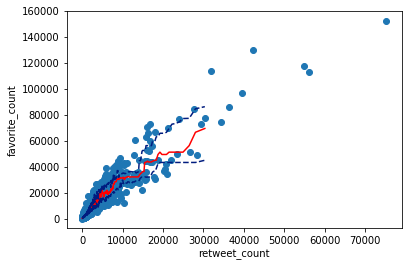

In [355]:
# compute statistics in a rolling window
df_window = tmp_master.sort_values('retweet_count').rolling(25)
x_winmean = df_window.retweet_count.mean()
y_median = df_window.favorite_count.median()
y_q1 = df_window.favorite_count.quantile(.25)
y_q3 = df_window.favorite_count.quantile(.75)

# plot the summarized data
base_color = sns.color_palette()[0]
line_color = sns.color_palette('dark')[0]
plt.scatter(data = tmp_master, x = 'retweet_count', y = 'favorite_count')
plt.errorbar(x = x_winmean, y = y_median, c = 'r')
plt.errorbar(x = x_winmean, y = y_q1, c = line_color, linestyle = '--')
plt.errorbar(x = x_winmean, y = y_q3, c = line_color, linestyle = '--')

plt.xlabel('retweet_count')
plt.ylabel('favorite_count')

In [374]:
predict=twitter_master.query('First_dog == True')
predict.shape

(1477, 22)

C:\Users\Marc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(4000, 10000)

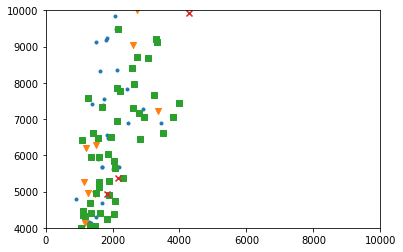

In [401]:
sedan_classes = ['doggo', 'puppo', 'pupper', 'floofer']
cat_markers=[['doggo','.'],[ 'puppo', 'v'],[ 'pupper', 's'],['floofer','x']]
vclasses = pd.api.types.CategoricalDtype(ordered=True, categories=sedan_classes)
tmp_master['stage'] = tmp_master['stage'].astype(vclasses);


for cat, marker in cat_markers:
    df_cat = tmp_master[tmp_master['stage'] == cat]
    plt.scatter(data = df_cat, x = 'retweet_count', y = 'favorite_count', marker = marker)
plt.xlim(0,10000)
plt.ylim(4000,10000)

TypeError: can't multiply sequence by non-int of type 'float'

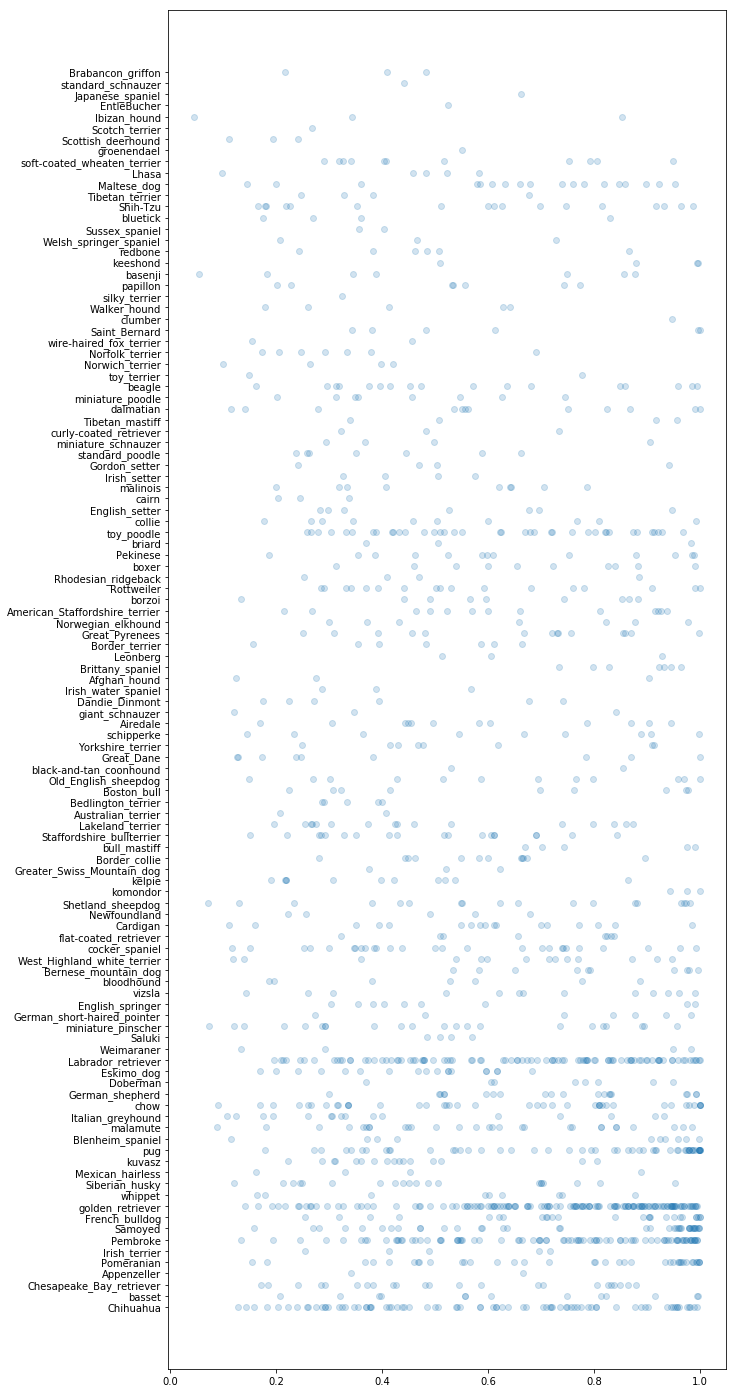

In [375]:
plt.figure(figsize=(10,25))
sns.regplot(data=predict,y='First_breed',x='First_confidence',scatter_kws={'alpha':1/5});

C:\Users\Marc\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Marc\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 79.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


(-14442.329214511712, 89711.3292145117)

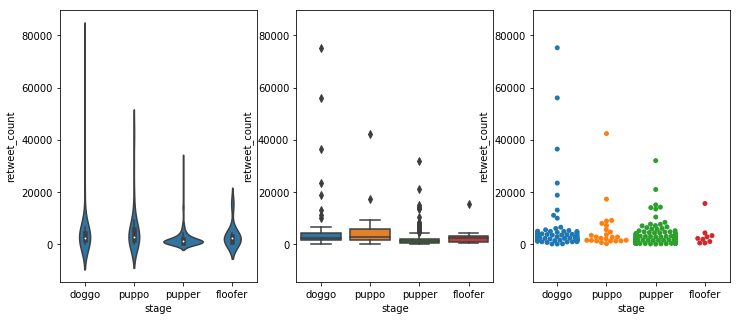

In [380]:
plt.figure(figsize = [12, 5])
base_color = sns.color_palette()[0]
plt.subplot(1, 3, 1)
ax1 = sns.violinplot(data=tmp_master,x='stage',y='retweet_count', color=base_color);

plt.subplot(1, 3, 2)
sns.boxplot(data=tmp_master,x='stage',y='retweet_count');
plt.ylim(ax1.get_ylim()) # set y-axis limits to be same as left plot

# right plot: swarm plot
plt.subplot(1, 3, 3)
sns.swarmplot(data=tmp_master,x='stage',y='retweet_count');
plt.ylim(ax1.get_ylim())

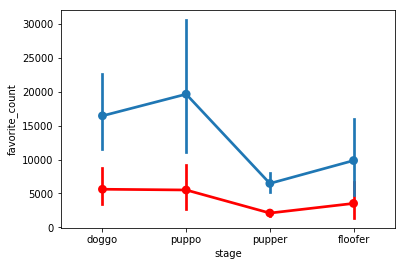

In [362]:
sns.pointplot(data=tmp_master,x='stage',y='retweet_count',color='r');
sns.pointplot(data=tmp_master,x='stage',y='favorite_count');

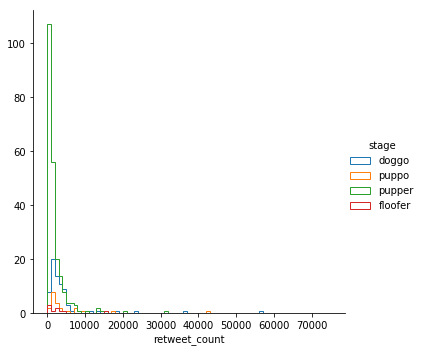

In [363]:
bin_edges = np.arange(-3, tmp_master['retweet_count'].max()+1, 1000)
g = sns.FacetGrid(data = tmp_master, hue = 'stage', height = 5)
g.map(plt.hist, "retweet_count", bins = bin_edges, histtype = 'step')
g.add_legend()

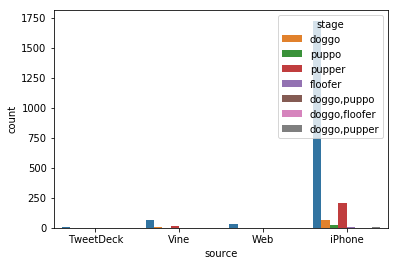

In [308]:
sns.countplot(data=twitter_master, x='source', hue='stage ');

In [316]:
ct_counts=twitter_master.groupby(['First_breed', 'Second_breed']).size()

In [317]:
ct_counts=ct_counts.reset_index(name='count')

In [318]:
ct_counts=ct_counts.pivot(index='First_breed',columns='Second_breed',values='count')

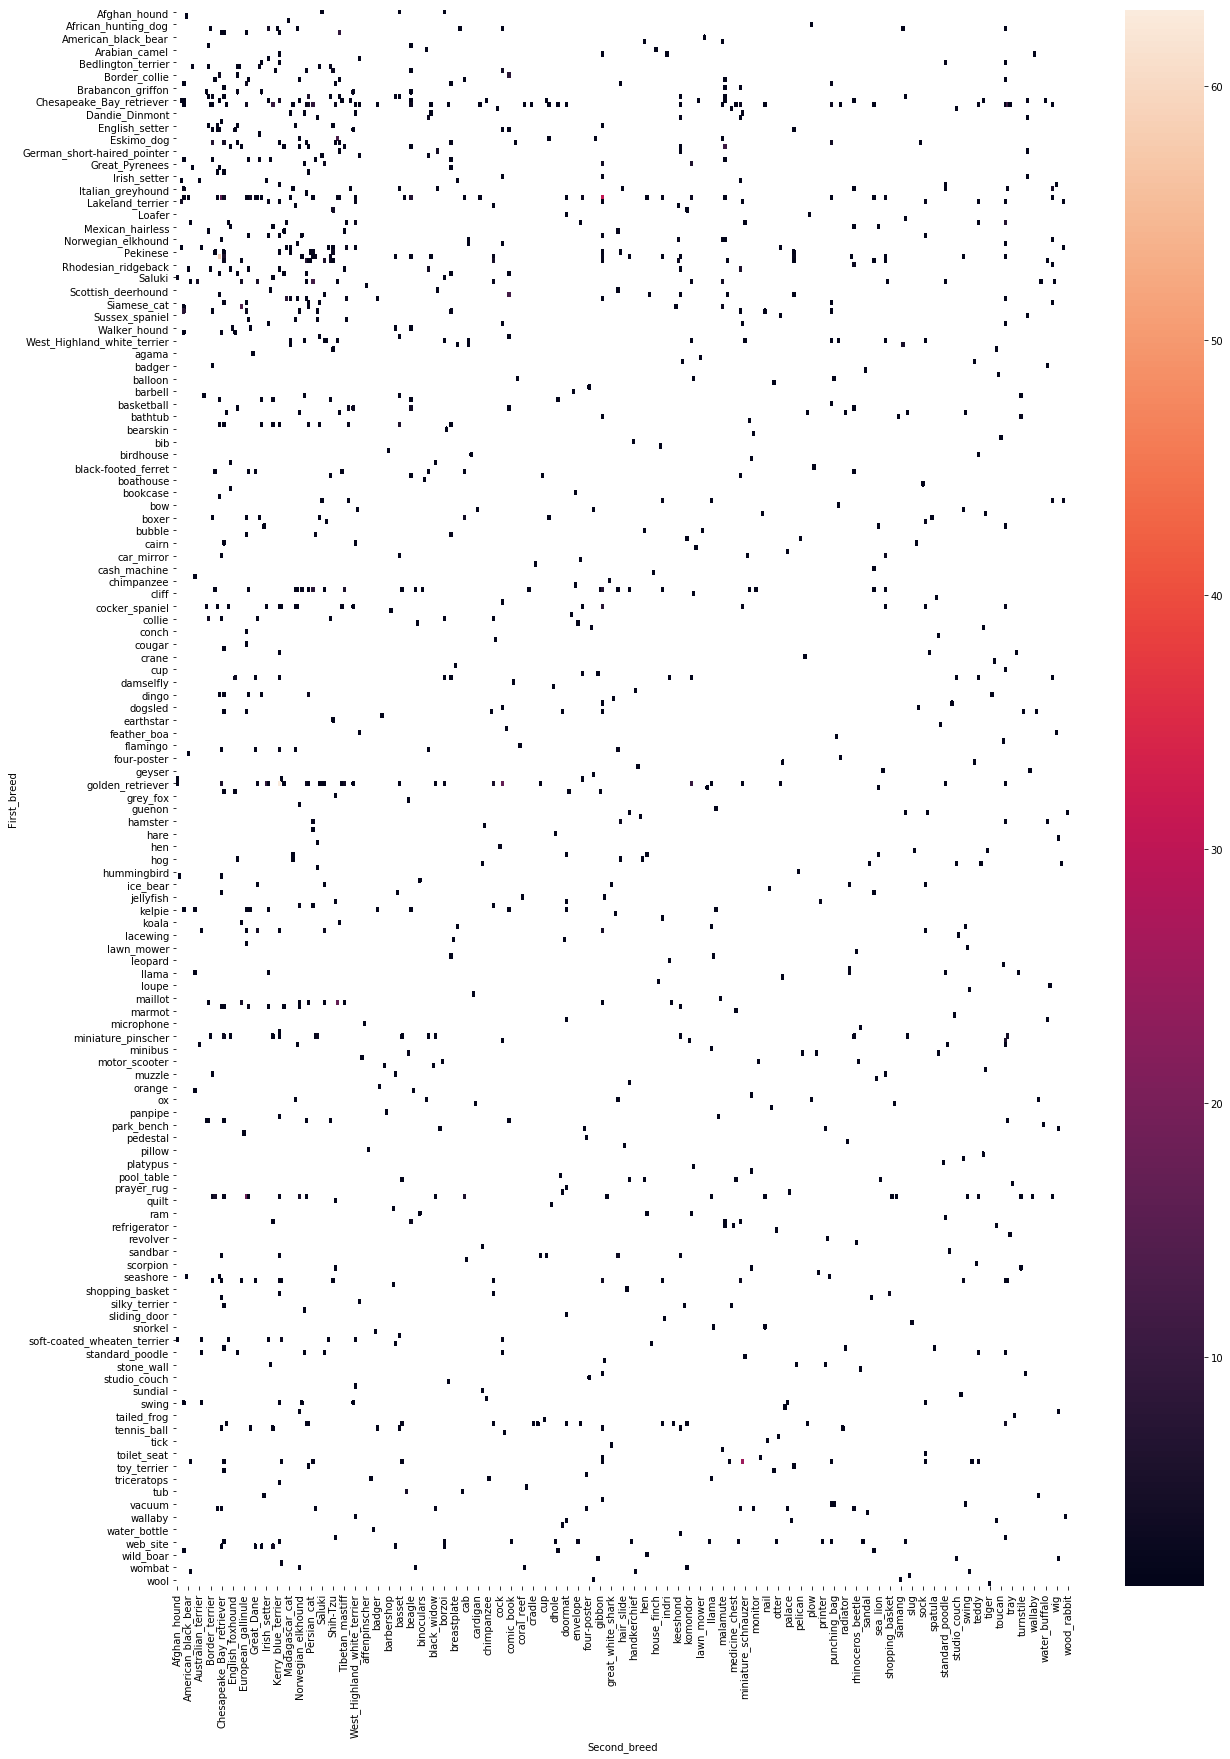

In [321]:
plt.figure(figsize=(20,29))
sns.heatmap(ct_counts)

C:\Users\Marc\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Marc\anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


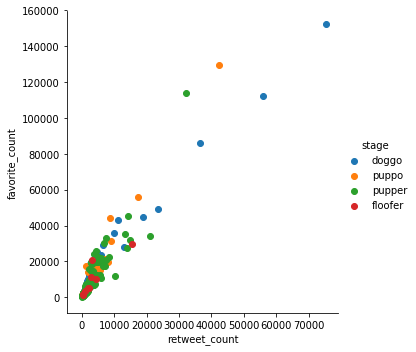

In [415]:
sedan_classes = ['doggo', 'puppo', 'pupper', 'floofer']
cat_markers=[['doggo','.'],[ 'puppo', 'v'],[ 'pupper', 's'],['floofer','x']]
vclasses = pd.api.types.CategoricalDtype(ordered=True, categories=sedan_classes)
tmp_master['stage'] = tmp_master['stage'].astype(vclasses);

g = sns.FacetGrid(data = tmp_master, hue = 'stage',size=5)
g.map(plt.scatter , 'retweet_count', 'favorite_count')
g.add_legend()

In [393]:
group_means = tmp_master.groupby(['stage']).count()
group_order = group_means.sort_values(['stage'], ascending = False).index

g = sns.FacetGrid(data = tmp_master, row = 'stage', height = 0.75, aspect = 7)
g.map(sns.kdeplot, 'retweet_count', shade = True)
g.set_titles('{stage}')

ValueError: Image size of 378x90828 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 378x90828 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 378x90828 with 1682 Axes>

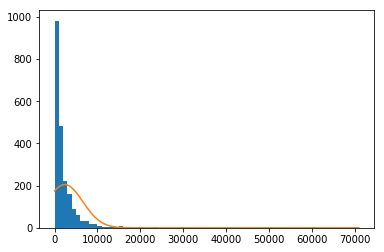

In [369]:
# create a histogram of the data
bin_size = 1000
bin_edges = np.arange(0, 70000 +bin_size, bin_size)
plt.hist(data = tmp_master, x = 'retweet_count', bins = bin_edges);

# overlay a theoretical normal distribution on top
samp_mean = tmp_master['retweet_count'].mean()
samp_sd = tmp_master['retweet_count'].std()

from scipy.stats import norm
x = np.linspace(0, 70000 +bin_size, bin_size)
y = norm.pdf(x, samp_mean, samp_sd) # normal distribution heights
y *= tmp_master.shape[0] * bin_size # scale the distribution height

plt.plot(x, y);

Text(0, 0.5, 'Observed Values')

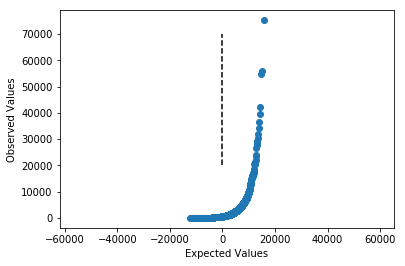

In [372]:
df=tmp_master
n_points = df.shape[0]
qs = (np.arange(n_points) - .5) / n_points
expected_vals = norm.ppf(qs, samp_mean, samp_sd)

plt.scatter(expected_vals, df['retweet_count'].sort_values())
plt.plot([0,0],[20000,70000],'--', color = 'black')
plt.axis('equal')
plt.xlabel('Expected Values')
plt.ylabel('Observed Values')